In [0]:
import numpy as np
import random as rand
from math import log, exp
import sys
import matplotlib.pyplot as plt
import time

In [0]:
class bandit(object):

  def __init__(self, arms = 10, variation = 1.5, change_rate = 0):
    self.arms = arms
    self.change_rate = change_rate
    self.bandit_means = []
    self.bandit_velocities = np.random.normal(0, self.change_rate*3, (self.arms,))
    for i in range(arms):
      self.bandit_means.append(abs(np.random.normal(0, variation)))
    self.best_mean = max(self.bandit_means)

  def make_bandit_predction(self, lever_index):
    number = rand.randint(0, 20 + int(100 * max(self.bandit_means + [1])))
    self.bandit_means = list(np.asarray(self.bandit_means) + np.asarray(self.bandit_velocities))
    self.bandit_velocities += np.random.normal(0, self.change_rate, (self.arms,))
    return int(number < 100 * self.bandit_means[lever_index])

In [0]:
class random_guessing(object):

  def __init__(self, arms = 10):
    self.arms = arms
    self.step_sizes = 0
    self.prediction_info = []

  def make_prediction(self, bandit):
    prediction = rand.randint(0, self.arms - 1)
    reward = bandit.make_bandit_predction(prediction)
    self.step_sizes += 1
    info = {"prediction": prediction, "reward": reward, "avg_reward": (sum([i["reward"] for i in self.prediction_info]) + reward) / self.step_sizes, "a": sum([i["reward"] for i in self.prediction_info]), "b": self.step_sizes}
    self.prediction_info.append(info)
    return self

In [0]:
class greedy(object):

  def __init__(self, optimism = 0, arms = 10, e = 0, stationary = True, a = 0.05):
    self.a = a
    self.probs = [optimism for i in range(arms)]
    self.e = e
    self.prediction_info = []
    self.step_sizes = [1 for i in range(arms)]
    self.arms, self.optimism  = arms, optimism
    self.stationary = stationary

  def make_prediction(self, bandit):
    if rand.randint(0,self.e*10) == 0:
      prediction = np.argmax(self.probs)
    else:
      prediction = rand.randint(0, self.arms - 1)
    reward = bandit.make_bandit_predction(prediction)
    if self.stationary:
      self.probs[prediction] += (reward - self.probs[prediction]) / self.step_sizes[prediction]
    else:
      self.probs[prediction] += a * (reward - self.probs[prediction])
    self.step_sizes[prediction] += 1
    info = {"prediction": prediction, "probabilities": self.probs.copy(), "reward": reward, "avg_reward": (sum([i["reward"] for i in self.prediction_info]) + reward) / sum(self.step_sizes)}
    self.prediction_info.append(info)
    return self

In [0]:
class gradient_bandit(object):

  def __init__(self, optimism = 0, arms = 10, a=0.01):
    self.probs = [optimism for i in range(arms)]
    self.a = a
    self.prediction_info = [{"prediction": 0, "probabilities": [], "reward": 0, "avg_reward": 0}]
    self.step_sizes = [1 for i in range(arms)]
    self.arms, self.optimism  = arms, optimism

  def make_prediction(self, bandit):
    prediction = np.argmax(list(map(lambda x: exp(x) / sum(map(lambda x: exp(x), self.probs)), self.probs)))
    reward = bandit.make_bandit_predction(prediction)
    self.probs[prediction] += self.a * (reward - self.prediction_info[-1]["avg_reward"]) * (1 - exp(self.probs[prediction])/sum(map(lambda x: exp(x), self.probs)))
    temp = self.probs[prediction]
    del self.probs[prediction]
    self.probs -= self.a * (reward - self.prediction_info[-1]["avg_reward"]) * (np.array(list(map(lambda y: exp(y)/sum(map(lambda x: exp(x), self.probs)), self.probs))))
    self.probs = list(self.probs[:prediction]) + [temp] + list(self.probs[prediction:])
    self.step_sizes[prediction] += 1
    info = {"prediction": prediction, "probabilities": self.probs.copy(), "reward": reward, "avg_reward": (sum([i["reward"] for i in self.prediction_info]) + reward) / sum(self.step_sizes)}
    self.prediction_info.append(info)
    return self

In [0]:
class UCB(object):

  def __init__(self, optimism = 0, arms = 10, c=0.1):
    self.probs = [optimism for i in range(arms)]
    self.c = c
    self.prediction_info = []
    self.step_sizes = [1 for i in range(arms)]
    self.arms, self.optimism  = arms, optimism

  def make_prediction(self, bandit):
    prediction = np.argmax(self.probs + self.c * np.array(list(map(lambda x : x**(1/2), np.array([sum(self.step_sizes) for i in self.step_sizes]) / self.step_sizes))))
    reward = bandit.make_bandit_predction(prediction)
    self.probs[prediction] += (reward - self.probs[prediction]) / self.step_sizes[prediction]
    self.step_sizes[prediction] += 1
    info = {"prediction": prediction, "probabilities": self.probs.copy(), "reward": reward, "avg_reward": (sum([i["reward"] for i in self.prediction_info]) + reward) / sum(self.step_sizes)}
    self.prediction_info.append(info)
    return self

In [0]:
bandit_1 = []
train_time = 300
avgs = 40

greedy_list = [[],[],[],[],[]]
UCB_list = [[],[]]
gradient_list = [[],[]]
random_guesser = []

toolbar_width = 40
if toolbar_width > avgs:
  raise KeyError(f"Toolbar_width must be smaller than or equal to avgs. Toolbar_width={toolbar_width}; avgs={avgs}.")
elif avgs % toolbar_width != 0:
  raise KeyError(f"Toolbar_width must be a factor of avgs. Toolbar_width={toolbar_width}; avgs={avgs}.")
print("[", end="")
for i in range(toolbar_width + 5):
  print("#", end="")

for j in range(avgs): ## train multiple times to then take the average

  bandit_1.append(bandit())
  greedy_list[0].append(greedy())
  greedy_list[1].append(greedy(optimism = 10))
  greedy_list[3].append(greedy(e = 0.2))
  greedy_list[4].append(greedy(e = 0.4))
  greedy_list[2].append(greedy(optimism = 100))
  UCB_list[0].append(UCB(c = 0.05))
  UCB_list[1].append(UCB())
  gradient_list[0].append(gradient_bandit(a = 0.005))
  gradient_list[1].append(gradient_bandit())
  random_guesser.append(random_guessing())

  if j % int(avgs / 40) == 0:
    for i in range(toolbar_width + 5):
      print("\b", end="")
    print("#", end="")
    toolbar_width -= 1
    for i in range(toolbar_width):
      print("-", end="")
    print(f"] {str(int(((j / int(avgs / 40))/40)*100)).rjust(2, ' ')}%", end="")

  for i in range(train_time): ## training loop

    greedy_list[0][j].make_prediction(bandit_1[j])
    greedy_list[1][j].make_prediction(bandit_1[j])
    greedy_list[2][j].make_prediction(bandit_1[j])
    greedy_list[3][j].make_prediction(bandit_1[j])
    greedy_list[4][j].make_prediction(bandit_1[j])
    UCB_list[0][j].make_prediction(bandit_1[j])
    UCB_list[1][j].make_prediction(bandit_1[j])
    gradient_list[0][j].make_prediction(bandit_1[j])
    gradient_list[1][j].make_prediction(bandit_1[j])
    random_guesser[j].make_prediction(bandit_1[j])

print("\b\b\b100%")

[##############################################---------------------------------------]  0%#--------------------------------------]  2%#-------------------------------------]  5%#------------------------------------]  7%#-----------------------------------] 10%#----------------------------------] 12%#---------------------------------] 15%#--------------------------------] 17%#-------------------------------] 20%#------------------------------] 22%#-----------------------------] 25%#----------------------------] 27%

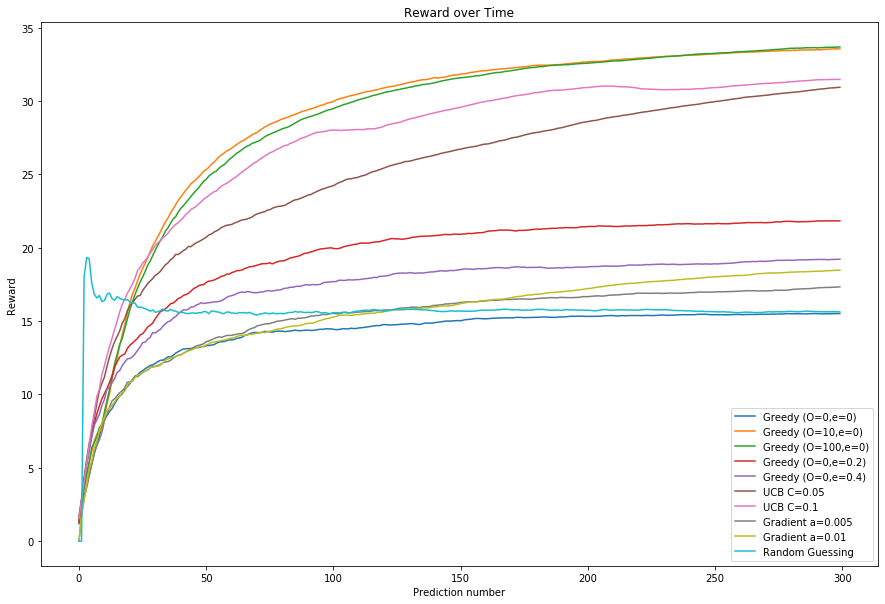

In [0]:
avg = []
for i in range(len(greedy_list) + len(UCB_list) + len(gradient_list) + 1):
  avg.append([0 for i in range(train_time)])

for i in range(len(greedy_list)):
  for j in greedy_list[i]: ## though each retrain
    for k in range(len(j.prediction_info)): ## through each timestep
      avg[i][k] += j.prediction_info[k]["avg_reward"] ## add timestep avg_reward to total timestep

next_idx = i
for i in range(next_idx + 1, next_idx + 1 + len(UCB_list)):
  for j in UCB_list[i - next_idx - 1]: ## though each retrain
    for k in range(len(j.prediction_info)): ## through each timestep
      avg[i][k] += j.prediction_info[k]["avg_reward"] ## add timestep avg_reward to total timestep

next_idx = i
for i in range(next_idx + 1, next_idx + 1 + len(gradient_list)):
  for j in gradient_list[i - next_idx - 1]: ## though each retrain
    for k in range(1, len(j.prediction_info) - 1): ## through each timestep
      avg[i][k] += j.prediction_info[k]["avg_reward"] ## add timestep avg_reward to total timestep7

for j in random_guesser: ## though each retrain
  for k in range(1, len(j.prediction_info) - 1): ## through each timestep
    avg[i + 1][k+1] += j.prediction_info[k]["avg_reward"] ## (not sure why this one needs to add one to k but it works)
      
plt.rcParams["figure.figsize"] = (15,10)
plt.title('Reward over Time')
for i in avg:
  plt.plot(i)
plt.ylabel('Reward')
plt.xlabel('Prediction number')
plt.legend(['Greedy (O=0,e=0)','Greedy (O=10,e=0)', 'Greedy (O=100,e=0)', 'Greedy (O=0,e=0.2)', 'Greedy (O=0,e=0.4)', 'UCB C=0.05', 
            'UCB C=0.1', 'Gradient a=0.005', 'Gradient a=0.01', 'Random Guessing'], loc='lower right')
plt.show()

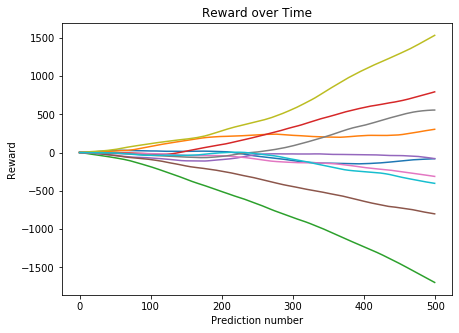

In [0]:
bandit_2 = bandit(change_rate=0.1)

means = []
for i in range(500):
  a = bandit_2.make_bandit_predction(0)
  means.append(bandit_2.bandit_means)

plt.rcParams["figure.figsize"] = (7,5)
plt.title('Reward over Time')
for i in range(len(means[0])):
  plt.plot(np.array(means)[:,i])
plt.ylabel('Reward')
plt.xlabel('Prediction number')
plt.show()

In [0]:
bandit_1 = []
train_time = 700
avgs = 480

greedy_list = [[],[]]

toolbar_width = 40
if toolbar_width > avgs:
  raise KeyError(f"Toolbar_width must be smaller than or equal to avgs. Toolbar_width={toolbar_width}; avgs={avgs}.")
elif avgs % toolbar_width != 0:
  raise KeyError(f"Toolbar_width must be a factor of avgs. Toolbar_width={toolbar_width}; avgs={avgs}.")
print("[", end="")
for i in range(toolbar_width + 5):
  print("#", end="")

for j in range(avgs): ## train multiple times to then take the average

  bandit_1.append(bandit(change_rate = 0.1))
  greedy_list[0].append(greedy(optimism = 10))
  greedy_list[1].append(greedy(stationary = False, optimism = 10))

  if j % int(avgs / 40) == 0:
    for i in range(toolbar_width + 5):
      print("\b", end="")
    print("#", end="")
    toolbar_width -= 1
    for i in range(toolbar_width):
      print("-", end="")
    print(f"] {str(int(((j / int(avgs / 40))/40)*100)).rjust(2, ' ')}%", end="")

  for i in range(train_time): ## training loop

    greedy_list[0][j].make_prediction(bandit_1[j])
    greedy_list[1][j].make_prediction(bandit_1[j])

print("\b\b\b100%")

[##############################################---------------------------------------]  0%#--------------------------------------]  2%#-------------------------------------]  5%#------------------------------------]  7%#-----------------------------------] 10%#----------------------------------] 12%#---------------------------------] 15%#--------------------------------] 17%#-------------------------------] 20%#------------------------------] 22%#-----------------------------] 25%#----------------------------] 27%

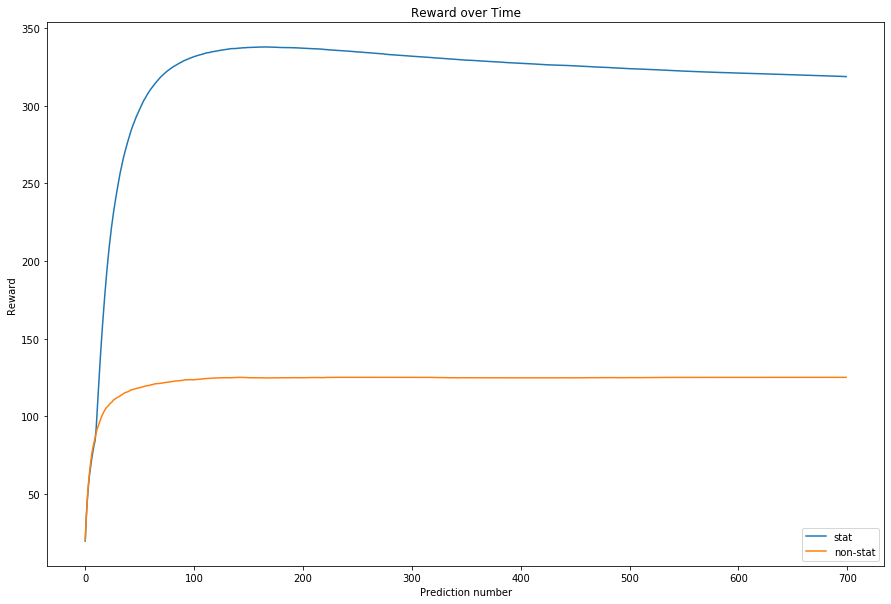

In [0]:
avg = []
for i in range(len(greedy_list)):
  avg.append([0 for i in range(train_time)])

for i in range(len(greedy_list)):
  for j in greedy_list[i]: ## though each retrain
    for k in range(len(j.prediction_info)): ## through each timestep
      avg[i][k] += j.prediction_info[k]["avg_reward"] ## add timestep avg_reward to total timestep

plt.rcParams["figure.figsize"] = (15,10)
plt.title('Reward over Time')
for i in avg:
  plt.plot(i)
plt.ylabel('Reward')
plt.xlabel('Prediction number')
plt.legend(['stat', 'non-stat'], loc='lower right')
plt.show() ## tbh this one really didn't work well

In [0]:
def display_grid(state, size, temp):
  (A1, B1, A2, B2) = temp
  
  grid = [[" " for i in range(size[0])] for i in range(size[1])]
  grid[A1[1]][A1[0]] = "A"
  grid[B1[1]][B1[0]] = "B"
  grid[state[1]][state[0]] = "V"

  print("".join(["-" for i in range(4 * grid_width + 1)]))
  for i in range(size[1]):
    print("| " + "".join([str(j) + " | " for j in grid[i]]))
    print("".join(["-" for i in range(4 * grid_width + 1)]))

In [0]:
def update_state(direction, state, size, display = True):
  A1, B1 = (3, 3), (5, 3) ## gives one reward then moves agent to #2
  A2, B2 = (3, 7), (5, 7)
  landmarks = (A1, B1, A2, B2)

  reward = 0

  try:
    state = (state[0] + direction[0], state[1] + direction[1])
    if state == A1:
      state = A2
      reward = 3
    elif state == B1:
      state = B2
      reward = 1
    if display:
      display_grid(state, size, landmarks)
  except:
    reward = 0
  return state, reward

In [0]:
grid_width, grid_height = 10, 10

state = (0, 0) ## (0,0) is the top left

for i in range(5):
  time.sleep(0.5)
  print("".join(["\b" for i in range(1000)]))
  direction = (1, 0)
  state, reward = update_state(direction, state, (grid_width, grid_height))
  print(reward)

for i in range(4):
  time.sleep(0.5)
  print("".join(["\b" for i in range(1000)]))
  direction = (0, 1)
  state, reward = update_state(direction, state, (grid_width, grid_height))
  print(reward)



In [0]:
def compute_state_value(state_y, state_x, values, pi, gamma, A1, B1): # 0>^;1>>;2>v;3><

  if (state_x, state_y) == A1:
    reward =  3
    return reward + gamma * values[7][3]
  elif (state_x, state_y) == B1:
    reward = 1
    return reward + gamma * values[7][5]

  numbers = []
  try:
    numbers.append(gamma * values[state_y - 1][state_x])
  except:
    pass
  try:
    numbers.append(gamma * values[state_y][state_x + 1])
  except:
    pass
  try:
    numbers.append(gamma * values[state_y + 1][state_x])
  except:
    pass
  try:
    numbers.append(gamma * values[state_y][state_x - 1])
  except:
    pass
  
  return max(numbers)


def get_state_values_actions(size, epochs = 20, gamma = 0.9, theta = 1): ## gamma controls how much it looks into the future; theta dictates how good the value function should be before the iterations stop
  A1, B1 = (3, 3), (5, 3) ## gives one reward then moves agent to #2
  
  values = [[0 for i in range(size[1])] for i in range(size[0])] ## current value function
  pi = [[0 for i in range(size[1])] for i in range(size[0])] ## current policy

  for i in range(epochs):

    policy_stable = False

    while not policy_stable:

      change = 0
      change = 0
      for state_y in range(len(values)):
        for state_x in range(len(values[0])):
          v = values[state_y][state_x]
          values[state_y][state_x] = compute_state_value(state_y, state_x, values, pi, gamma, A1, B1)
          change = max(change, abs(v - values[state_y][state_x]))

      policy_stable = True

      for state_y in range(len(values)):
          for state_x in range(len(values[0])):

            old_action = pi[state_y][state_x]

            list_values = []
            
            try:
              list_values.append(values[state_y - 1][state_x])
            except:
              list_values.append(0)
            try:
              list_values.append(values[state_y][state_x + 1])
            except:
              list_values.append(0)
            try:
              list_values.append(values[state_y + 1][state_x])
            except:
              list_values.append(0)
            try:
              list_values.append(values[state_y][state_x - 1])
            except:
              list_values.append(0)

            pi[state_y][state_x] = np.argmax(list_values)

            if old_action != pi[state_y][state_x]:
              policy_stable = False

    return values, pi

In [0]:
grid_width, grid_height = 10, 10

state = (0, 0) ## (0,0) is the top left

values, pi = get_state_values_actions((grid_width, grid_height))

print("values:")
for i in values:
  print("".join(['|{0:>5}'.format(round(j, 3)) for j in i]))

print("\n\nActions:")
for i in pi:
  print("".join(['|{0:>2} '.format(j) for j in i]))

values:
|2.536|3.435|4.222|4.957|4.461|4.015|3.614|3.252|2.927|2.634
|3.435|4.222|4.957|5.682|5.114|4.603|4.142|3.728|3.355| 3.02
|4.222|4.957|5.682|6.428|5.785|5.207|4.686|4.218|3.796|3.416
|4.957|5.682|6.428|7.218|6.496|4.416|4.218|3.796|3.416|3.075
|4.461|5.114|5.785|6.496|5.846|5.262|4.735|4.262|3.836|3.452
|4.015|4.603|5.207|5.846|5.262|4.735|4.262|3.836|3.452|3.107
|3.614|4.142|4.686|5.262|4.735|4.262|3.836|3.452|3.107|2.796
|3.252|3.728|4.218|4.735|4.262|3.836|3.452|3.107|2.796|2.517
|2.927|3.355|3.796|4.262|3.836|3.452|3.107|2.796|2.517|2.265
|2.634| 3.02|3.416|3.836|3.452|3.107|2.796|2.517|2.265|2.038


Actions:
| 1 | 1 | 1 | 2 | 2 | 2 | 2 | 2 | 2 | 2 
| 1 | 1 | 1 | 2 | 2 | 2 | 2 | 2 | 2 | 2 
| 1 | 1 | 1 | 2 | 2 | 3 | 3 | 3 | 3 | 3 
| 1 | 1 | 1 | 1 | 3 | 3 | 2 | 2 | 2 | 2 
| 1 | 1 | 1 | 0 | 0 | 3 | 3 | 3 | 3 | 3 
| 1 | 1 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 0 
| 1 | 1 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 0 
| 1 | 1 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 0 
| 1 | 1 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 0 
| 

In [0]:
grid_width, grid_height = 10, 10 ## size of grid
speed = 2 ## >3 is a bit buggy
timesteps = 10
iterations = 5

broken = False
for j in range(iterations):
  state = (rand.randint(0, 9), rand.randint(0, 9)) ## (0,0) is the top left. This is the starting state
  values, pi = get_state_values_actions((grid_width, grid_height))
  for i in range(timesteps):
    try:
      time.sleep(1/speed)
      print("".join(["\b" for i in range(1000)]))
      direction = pi[state[1]][state[0]]
      if direction == 0:
        direction = (0, -1)
      elif direction == 1:
        direction = (1, 0)
      elif direction == 2:
        direction = (0, 1)
      else:
        direction = (-1, 0)
      print(f"Iteration: {j+1}")
      state, reward = update_state(direction, state, (grid_width, grid_height))
      print(f"Direction: {direction}")
      print(f"Reward: {reward}")
      print(f"Timestep: {i + 1}")
    except:
      print("".join(["\b" for i in range(1000)]), "Went off the edge of the area")
      broken = True
      break
  print("".join(["\b" for i in range(1000)]))
  print("Restarting...\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n")
  time.sleep(0.2)
if not broken:
  print("".join(["\b" for i in range(1000)]), "Done.")



In [0]:
from itertools import chain

class black_jack(object):
  
  def __init__(self):

    self.end = False
    self.win = False

    self.cards = 4 * [[1,11],2,3,4,5,6,7,8,9,10,10,10,10]
    self.dealer_hand, self.player_hand = [], []
    for i in range(2):
      self.dealer_hand.append(rand.choice(self.cards))
      self.cards.remove(self.dealer_hand[-1])
    for i in range(2):
      self.player_hand.append(rand.choice(self.cards))
      self.cards.remove(self.dealer_hand[-1])

    if self.get_hand_value(self.player_hand) == 21:
      self.end, self.win = True, True

  def hit(self):

    self.player_hand.append(rand.choice(self.cards))
    self.cards.remove(self.dealer_hand[-1])

    if get_hand_value(self.player_hand) == 21:
      self.end, self.win = True, True
    elif get_hand_value(self.player_hand) > 21:
      self.end, self.win = True, False

    return self

  def stick(self):

    self.player_hand = get_hand_value(self.player_hand)
    while True:
      temp_value == get_hand_value(self.dealer_hand)
      if temp_value >= self.player_hand and temp_value <= 21:
        return True ## True => win
      elif temp_value > 21:
        return False ## False => lose
    raise StopIteration("Something has gone terribly wrong")

  def get_hand_value(self, hand):

    if [1,11] not in hand:
      hand = sum(hand)
    else:
      temp = []
      for i in hand:
        temp.append(11 if i == [1,11] else i)
      hand = sum(temp)
      if hand > 21:
        hand -= 10
    return hand

  def see_cards(self, verbose=True, blind=True):
    if blind:
      dealer_hand = self.dealer_hand[0], "X"
    else:
      dealer_hand = self.dealer_hand
    if verbose:
      return f"Your hand: ({self.player_hand[0]}, {self.player_hand[1]})\nDealer's hand: ({dealer_hand[0]}, {dealer_hand[1]})"
    else:
      return (self.player_hand, dealer_hand)

In [0]:
bj = black_jack()

print(bj.see_cards())
print(bj.get_hand_value(bj.player_hand))

Your hand: (10, 10)
Dealer's hand: (2, X)
20


(Wanted to move onto TD so skipped making a monte carlo program and didn't use the bj program)

In [0]:
class cliff_walk(object):

  def __init__(self, reward=1, penalty=-100, height=4, width=9):
    self.start_state = [height, 0]
    self.state = self.start_state
    self.penalty = penalty
    self.reward = reward

    self.height, self.width = height, width

    self.start_state = [height,0]
    self.cliff_states = tuple([[height, i] for i in range(1, width)])

    self.rewards = [0]
    self.states = [self.state.copy()]

  def display(self):
    for i in range(self.height+1):
      print("".join(["| V " if [i, j] == self.state else ("| X " if [i, j] in self.cliff_states else "| - ") for j in range(self.width+1)]) + "|")
  
  def move(self, direction): ## direction as tuple
    self.state[0] += direction[0]
    self.state[1] += direction[1]

    reward = 0

    if self.state in self.cliff_states: ## off cliff
      self.state = self.start_state
      reward = self.penalty
    elif self.state == [4,9]: ## at end
      self.state = self.start_state
      reward = self.reward
    elif self.state[0] < 0: ## off top
      self.state[0] = 0
    elif self.state[0] > self.height: ## off bottom
      self.state[0] = 4
    elif self.state[1] < 0: ## off left
      self.state[1] = 0
    elif self.state[1] > self.width: ## off right
      self.state[1] = width

    self.rewards.append(reward)
    self.states.append(self.state.copy())

    return reward, self.state

In [0]:
from time import sleep

cliff_walk_1 = cliff_walk()

direction = (-1, 0)
for i in range(10):
  print("".join(["\b" for i in range(235)]))
  cliff_walk_1.display()
  print(f"Reward: {cliff_walk_1.rewards[-1]}\nState: ({str(cliff_walk_1.states[-1])[1:5]})")
  reward, state = cliff_walk_1.move(direction)
  sleep(1)


| - | - | - | - | - | - | - | - | - | - |
| - | - | - | - | - | - | - | - | - | - |
| - | - | - | - | - | - | - | - | - | - |
| - | - | - | - | - | - | - | - | - | - |
| V | X | X | X | X | X | X | X | X | - |
Reward: 0
State: (4, 0)

| - | - | - | - | - | - | - | - | - | - |
| - | - | - | - | - | - | - | - | - | - |
| - | - | - | - | - | - | - | - | - | - |
| V | - | - | - | - | - | - | - | - | - |
| - | X | X | X | X | X | X | X | X | - |
Reward: 0
State: (3, 0)


KeyboardInterrupt: ignored

In [0]:
~